In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [81]:
def get_inital(T, N):
    r_range = np.zeros((N, 3))
    v_range = np.zeros((N, 3))
    angle_range = np.zeros((N, 3))
    omega_range = np.zeros((N, 3))
    t_range = np.linspace(0, T, N+1)[:-1]
    return r_range, v_range, angle_range, omega_range, t_range

def get_thrust(speeds, k):
    return k * speeds**2

def get_rotation_matrix(angles):
    phi, theta, psi = angles
    Ry =  np.array([[np.cos(theta), 0, -np.sin(theta)],
                    [0, 1, 0],
                    [np.sin(theta), 0, np.cos(theta)]])

    Rx =  np.array([[1, 0, 0],
                    [0, np.cos(phi), np.sin(phi)],
                    [0, -np.sin(phi), np.cos(phi)]])

    Rz =  np.array([[np.cos(psi), np.sin(psi), 0],
                    [-np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

    return (Rz @ Ry @ Rx)

def get_a(speeds, k, g, m, angle, direction):
    R = get_rotation_matrix(angle)
    T_b = np.array([0, 0, sum(get_thrust(speeds, k))])
    Fg = np.array([0, 0, m*g])
    R_direction = np.array([[direction[0], -direction[1], 0],
                            [direction[1], direction[0], 0],
                            [0, 0, 1]])
    return (Fg + R_direction @ R.T @ T_b) / m

def get_torque(speeds, k, l, b):
    Ti = get_thrust(speeds, k)
    tau_phi = l * (Ti[3] - Ti[1])
    tau_theta = l * (Ti[2] - Ti[0])
    tau_psi = 0
    for omega in speeds:
        if omega < 0:
            tau_psi += -b * omega**2
        else:
            tau_psi += b * omega**2
    return np.array([tau_phi, tau_theta, tau_psi])

def get_alpha(speeds, k, l, b, I, omega, angle):
    Ixx, Iyy, Izz = I
    torque = get_torque(speeds, k, l, b)

    p, q, r = omega
    alpha = np.array([(torque[0] + (Iyy - Izz)*q*r) / Ixx, 
                      (torque[1] + (Izz - Ixx)*p*r) / Iyy, 
                      (torque[2] + (Ixx - Iyy)*p*q) / Izz])
    return alpha

def func(y0, args):
    speeds, direction, k, b, m, l, I, g = args
    v = y0[3:6]
    angle = y0[6:9]
    omega = y0[9:12]

    a = get_a(speeds, k, g, m, angle, direction)
    alpha = get_alpha(speeds, k, l, b, I, omega, angle)

    return np.concatenate([v, a, omega, alpha])

def rk4(y0, dt, args):
    k1 = func(y0, args)
    k2 = func(y0 + dt*k1/2, args)
    k3 = func(y0 + dt*k2/2, args)
    k4 = func(y0 + dt*k3, args)
    return y0 + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

def plot_all(r_range, v_range, angle_range, omega_range, t_range):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    ax[0,0].plot(t_range, r_range[:,0], label=r"x")
    ax[0,0].plot(t_range, r_range[:,1], label=r"y")
    ax[0,0].plot(t_range, r_range[:,2], label=r"z")
    ax[0,0].set_xlabel("t (sec)")
    ax[0,0].set_ylabel("Displacement (m)")
    ax[0,0].set_title("Position")
    ax[0,0].legend()

    ax[0,1].plot(t_range, v_range[:,0], label=r"$V_x$")
    ax[0,1].plot(t_range, v_range[:,1], label=r"$V_y$")
    ax[0,1].plot(t_range, v_range[:,2], label=r"$V_z$")
    ax[0,1].set_xlabel("t (sec)")
    ax[0,1].set_ylabel("Velocity (m/s)")
    ax[0,1].set_title("Velocity")
    ax[0,1].legend()

    ax[1,0].plot(t_range, angle_range[:,0], label=r"$\phi$")
    ax[1,0].plot(t_range, angle_range[:,1], label=r"$\theta$")
    ax[1,0].plot(t_range, angle_range[:,2], label=r"$\psi$")
    ax[1,0].set_xlabel("t (sec)")
    ax[1,0].set_ylabel("Angle (rad)")
    ax[1,0].set_title("Euler Angles")
    ax[1,0].legend()

    ax[1,1].plot(t_range, omega_range[:,0], label=r"$p$")
    ax[1,1].plot(t_range, omega_range[:,1], label=r"$q$")
    ax[1,1].plot(t_range, omega_range[:,2], label=r"$r$")
    ax[1,1].set_xlabel("t (sec)")
    ax[1,1].set_ylabel("Angular Velocity (rad/s)")
    ax[1,1].set_title("Angular Velocity")
    ax[1,1].legend()
    plt.show()
    return

def plot_3D(r_range):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(r_range[:,0], r_range[:,1], r_range[:,2])
    plt.show()
    return

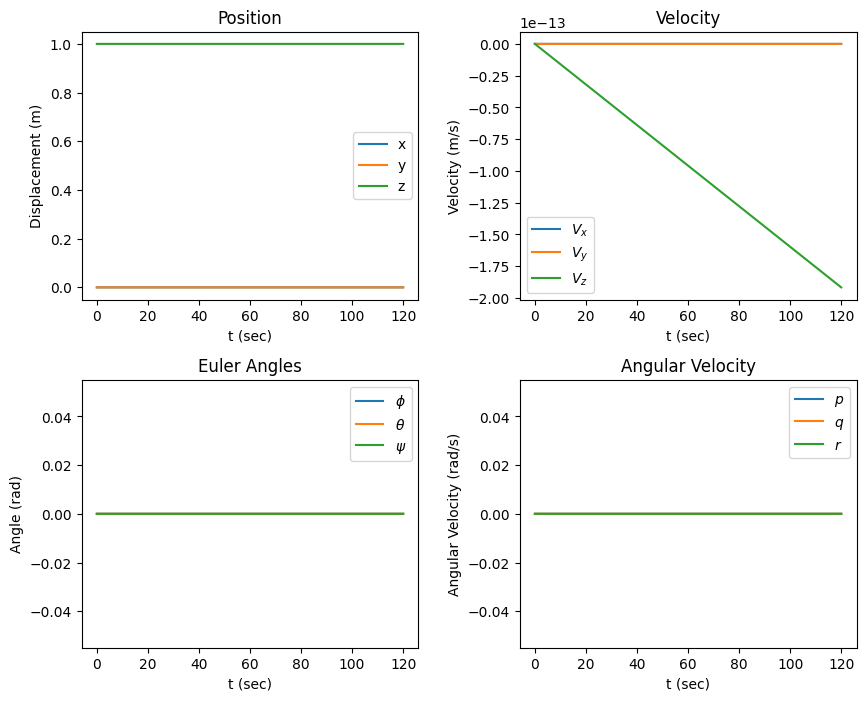

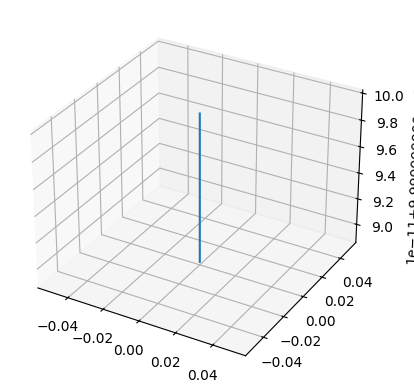

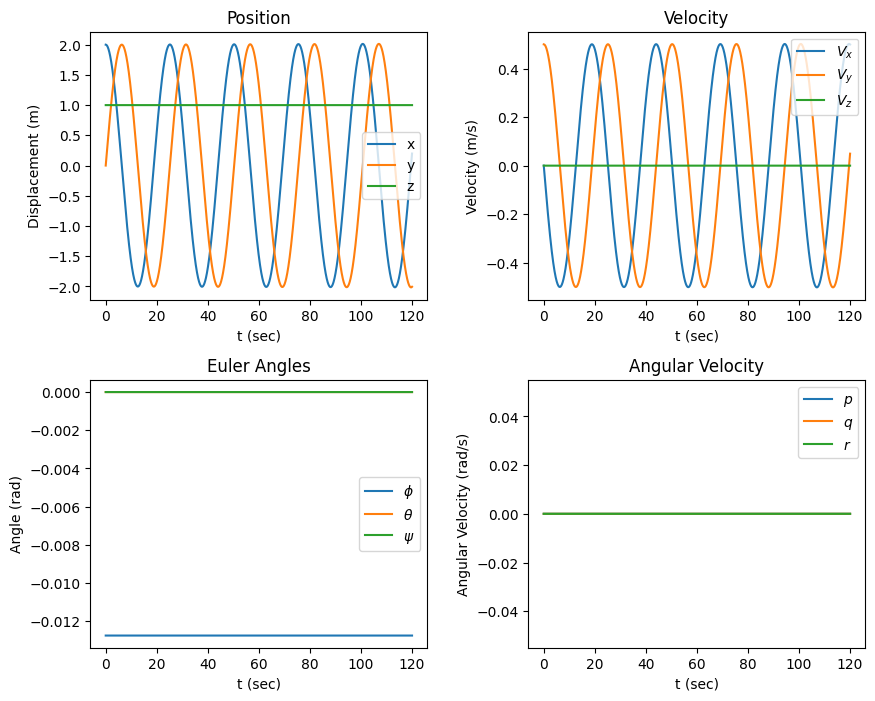

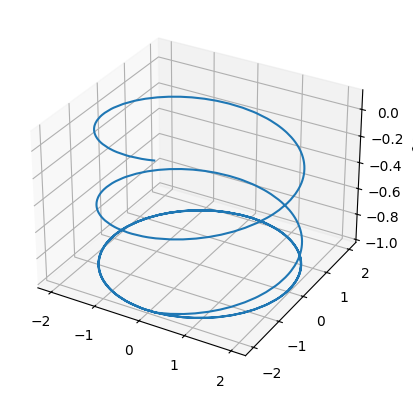

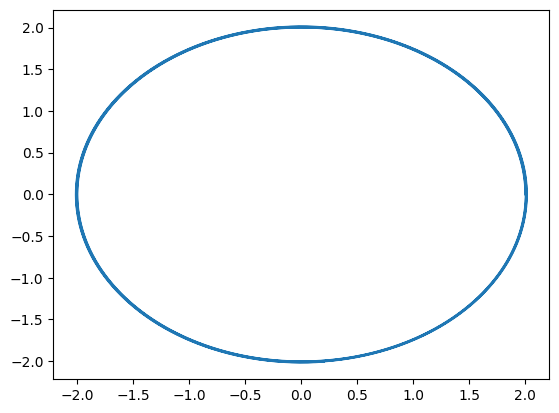

In [82]:
m = 0.139 # kg
g = -9.8 #m/s^2
Ixx = 0.00101954 #Rotational inertia about the X axis 
Iyy = 0.000998 #Rotational inertia about the Y axis 
Izz = 0.002 #Rotational inertia about the Z axis 
k = 5e-8 #Thrust Coefficient
b = 1e-10 #Torque Coeffiecient
l = np.sqrt(50) / 100 #arm length

I = np.array([Ixx, Iyy, Izz]) #rotational inertia matrix

dt = 0.001 #s
T = 120 #s
N = int(T / dt) # number of steps

#Hover
r_range, v_range, angle_range, omega_range, t_range = get_inital(T, N)
r_range[0] = np.array([0, 0, 1]) #hover 1m off ground

thrust_mag = -m * g
speed_mag = np.sqrt(thrust_mag / 4 / k)
speeds = np.array([speed_mag, -speed_mag, speed_mag, -speed_mag])

direction = np.array([0, 0, 1])
y0 = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])

for i in range(1, N):
    args = [speeds, direction, k, b, m, l, I, g]
    yn = rk4(y0, dt, args)

    r_range[i] = yn[0:3]
    v_range[i] = yn[3:6]
    angle_range[i] = yn[6:9]
    omega_range[i] = yn[9:12]
    
    y0 = y0 = np.concatenate([r_range[i], v_range[i], angle_range[i], omega_range[i]])
    direction = v_range[i] / np.linalg.norm(v_range[i])

plot_all(r_range, v_range, angle_range, omega_range, t_range)
plot_3D(r_range)

#Circle
circ_radius = 2 #m
hover_alt = 1 #m
quadcopter_speed = 0.5 #Speed of the quadcopter in m/s

r_range, v_range, angle_range, omega_range, t_range = get_inital(T, N)
r_range[0] = np.array([circ_radius, 0, hover_alt])
v_range[0] = np.array([0, quadcopter_speed, 0])

a_centripetal = -quadcopter_speed**2 / circ_radius 
a_g = -g
phi = np.arctan2(a_centripetal, a_g)

angle_range[0] = np.array([phi, 0, 0])

thrust_mag = m * np.sqrt(a_centripetal**2 + a_g**2)
speed_mag = np.sqrt(thrust_mag / 4 / k)
speeds = np.array([speed_mag, -speed_mag, speed_mag, -speed_mag])

direction = v_range[0] / np.linalg.norm(v_range[0])

y0 = np.concatenate([r_range[0], v_range[0], angle_range[0], omega_range[0]])
for i in range(1, N):
    args = [speeds, direction, k, b, m, l, I, g]
    yn = rk4(y0, dt, args)

    r_range[i] = yn[0:3]
    v_range[i] = yn[3:6]
    angle_range[i] = yn[6:9]
    omega_range[i] = yn[9:12]
    
    y0 = y0 = np.concatenate([r_range[i], v_range[i], angle_range[i], omega_range[i]])
    direction = v_range[i] / np.linalg.norm(v_range[i])

plot_all(r_range, v_range, angle_range, omega_range, t_range)
plot_3D(r_range)

plt.plot(r_range[:,0], r_range[:,1])